In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from tpot import TPOTClassifier
from sklearn.metrics import classification_report
import joblib
import warnings
import os

warnings.filterwarnings("ignore")

# --- Kaggle paths ---
DATA_PATH = "/kaggle/input/higgs-train/Z_boson-2.csv"   # <-- Adjust folder name if needed
OUTPUT_DIR = "/kaggle/working/"

# --- Load dataset ---
df = pd.read_csv(DATA_PATH)
print("Data loaded successfully.")

# --- Label encode categorical features ---
categorical_features = [
    # none for this dataset
]

label_encoders = {}

for col in categorical_features + ["class"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

# --- Features & Target ---
X = df.drop("class", axis=1)
y = df["class"]

# --- Scale ---
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# --- Train-test split ---
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.1, random_state=42
)

# --- TPOT GA Training ---
tpot = TPOTClassifier(
    generations=5,
    population_size=50,
    verbosity=2,
    random_state=42,
    n_jobs=-1
)
tpot.fit(X_train, y_train)

# --- Predictions ---
y_pred = tpot.predict(X_test)

# --- Evaluate ---
print(classification_report(y_test, y_pred))

# --- EXPORT & SAVE (Safe way in Kaggle) ---
tpot.export(os.path.join(OUTPUT_DIR, "ga_best_pipeline.py"))
print("Exported best TPOT pipeline.")

best_pipeline = tpot.fitted_pipeline_
joblib.dump(best_pipeline, os.path.join(OUTPUT_DIR, "genetic_algorithm_pipeline-higgs.pkl"))

joblib.dump(label_encoders, os.path.join(OUTPUT_DIR, "label_encoders-ga-higgs.pkl"))
joblib.dump(scaler, os.path.join(OUTPUT_DIR, "minmax_scaler-ga-higgs.pkl"))

print("✅ Saved pipeline, encoders, and scaler in Kaggle working directory.")

# --- Optional: save full TPOT object with dill ---
try:
    import dill
    with open(os.path.join(OUTPUT_DIR, "tpot_full_dill.pkl"), "wb") as f:
        dill.dump(tpot, f)
    print("Saved full TPOT object with dill.")
except Exception as e:
    print("Could not save TPOT object with dill (not critical). Error:", e)

# --- Plot classification report heatmap ---
import numpy as np

report_dict = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).iloc[:-1, :-1]

plt.figure(figsize=(10, 6))
sns.heatmap(report_df, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Classification Report Heatmap (TPOT Genetic Algorithm)")
plt.show()

# --- Scatter plots ---
df_raw = df.copy()
for col, le in label_encoders.items():
    df_raw[col] = le.inverse_transform(df[col])

features_to_plot = [
    "Run", "Event", "pt1", "eta1", "phi1", "Q1",
    "pt2", "eta2", "phi2", "Q2"
]

for feature in features_to_plot:
    plt.figure(figsize=(12, 6))
    sns.stripplot(
        x=feature, y="class", data=df_raw,
        jitter=True, palette="Set2", alpha=0.7, size=5
    )
    plt.title(f"class vs {feature}")
    plt.xlabel(feature)
    plt.ylabel("class")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd
import joblib

# ------------------------------
# Load saved objects
# ------------------------------
model = joblib.load("E:/LHC-CERN/genetic_algorithm_pipeline-higgs.pkl")
label_encoders = joblib.load("E:/LHC-CERN/label_encoders-gnn-higgs.pkl")
scaler = joblib.load("E:/LHC-CERN/minmax_scaler-gnn-higgs.pkl")

# ------------------------------
# Load the test dataset
# ------------------------------
test_df = pd.read_csv("/kaggle/input/higgs-train/Z_boson-2.csv")

# Keep a copy of original test inputs to save later
original_test_df = test_df.copy()

# Drop Date/Time if present

# Drop target column if present
if "class" in test_df.columns:
    test_df.drop(["class"], axis=1, inplace=True)

# ------------------------------
# Encode categorical features for model prediction
# ------------------------------
categorical_features = [
    
]

for col in categorical_features:
    if col in test_df.columns:
        le = label_encoders[col]
        test_df[col] = le.transform(test_df[col])

# ------------------------------
# Scale features
# ------------------------------
X_test_scaled = scaler.transform(test_df)

# ------------------------------
# Make predictions
# ------------------------------
preds_encoded = model.predict(X_test_scaled)

# ------------------------------
# Convert predictions back to original Accident Severity values
# ------------------------------
class_le = label_encoders["class"]
predicted_severity = class_le.inverse_transform(preds_encoded)

# ------------------------------
# Save predictions to CSV (keep original inputs)
# ------------------------------
output_df = original_test_df.copy()
output_df["Predicted_class"] = predicted_severity

output_path = "E:/LHC-CERN/class_higgs_predictions-genetic.csv"
output_df.to_csv(output_path, index=False)
print(f"✅ Predictions saved to {output_path}")

# Display first few predictions
output_df.head()
# ------------------------------
# Evaluate matches between actual and predicted class
# ------------------------------
if "class" in original_test_df.columns:
    output_df["Match"] = output_df["class"] == output_df["Predicted_class"]

    # Print overall accuracy
    accuracy = output_df["Match"].mean() * 100
    print(f"✅ Overall Match Accuracy: {accuracy:.2f}%")

    # Show a few rows where prediction was wrong
    mismatches = output_df[~output_df["Match"]]
    print(f"Total mismatches: {len(mismatches)}")
    print(mismatches.head())
else:
    print("⚠️ Original 'class' column not found in the dataset.")
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# ------------------------------
# Confusion matrix plot
# ------------------------------
if "class" in original_test_df.columns:
    y_true = output_df["class"]
    y_pred = output_df["Predicted_class"]

    cm = confusion_matrix(y_true, y_pred, labels=class_le.classes_)
    
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_le.classes_,
                yticklabels=class_le.classes_)
    plt.xlabel("Predicted Class")
    plt.ylabel("Actual Class")
    plt.title("Confusion Matrix(Genetic): Actual vs Predicted")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Original 'class' column not found in the dataset.")


Device: cpu
Data loaded successfully. Shape: (20000, 11)
DeepGCN(
  (blocks): ModuleList(
    (0): GCNBlock(
      (linear): Linear(in_features=10, out_features=512, bias=False)
      (bn): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
      (dropout): Dropout(p=0.4, inplace=False)
    )
    (1): GCNBlock(
      (linear): Linear(in_features=512, out_features=256, bias=False)
      (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
      (dropout): Dropout(p=0.4, inplace=False)
    )
    (2): GCNBlock(
      (linear): Linear(in_features=256, out_features=128, bias=False)
      (bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
      (dropout): Dropout(p=0.4, inplace=False)
    )
  )
  (classifier): Linear(in_features=128, out_features=2, bias=True)
  (projections): ModuleList(
    (0): Linear(in_features=10, out_features=5

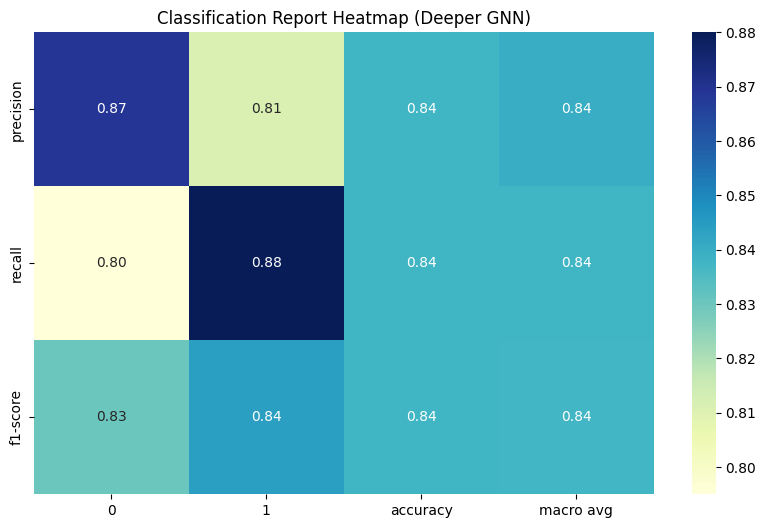

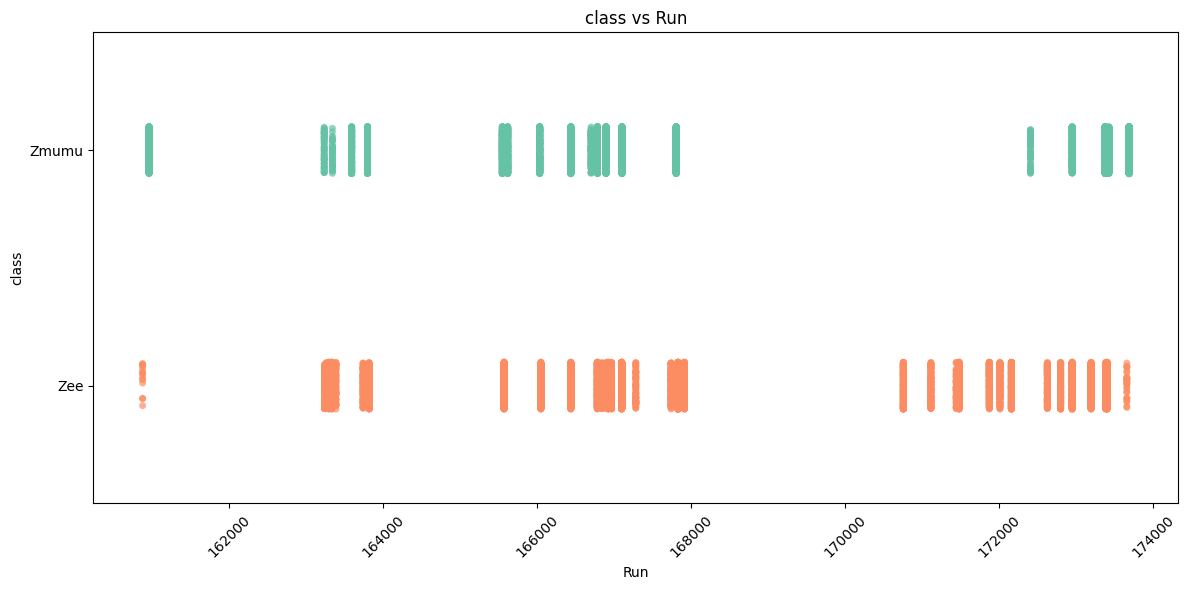

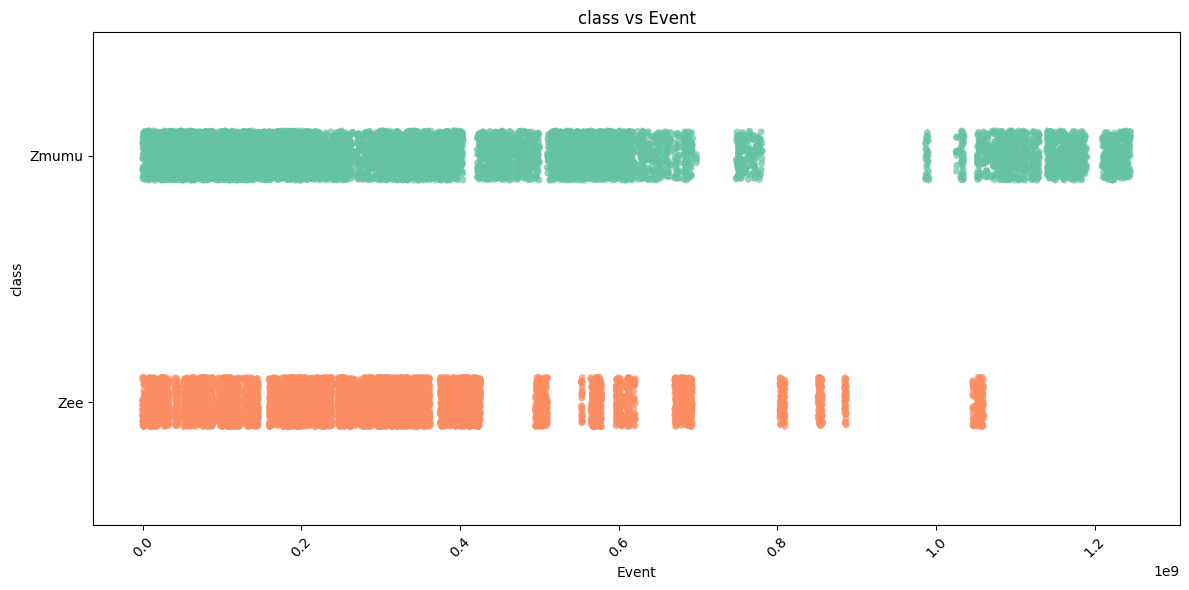

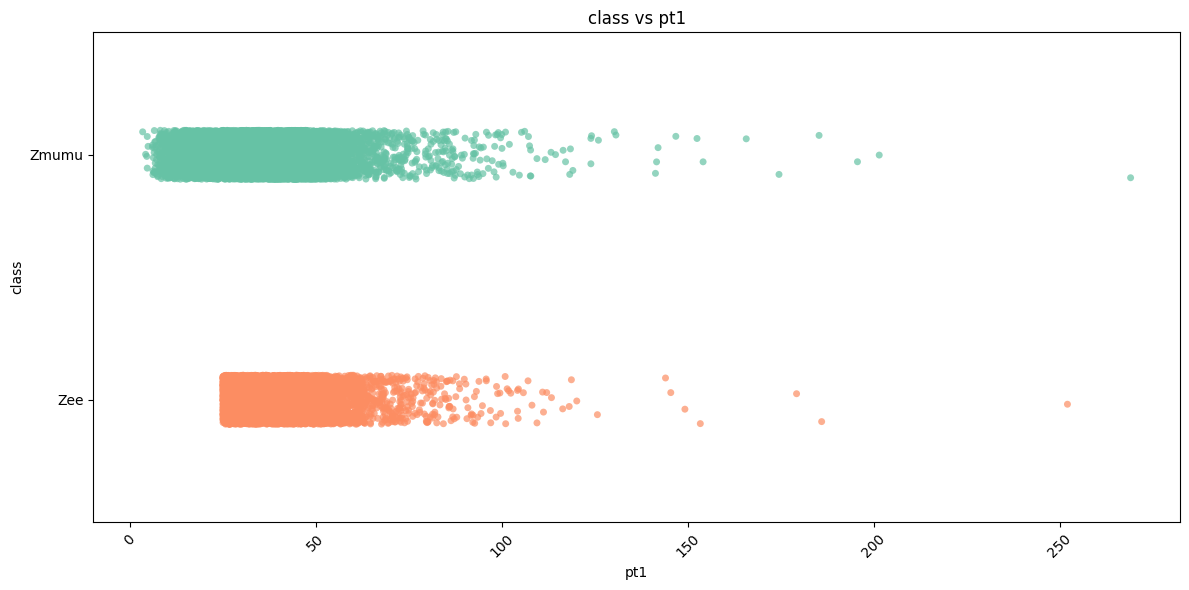

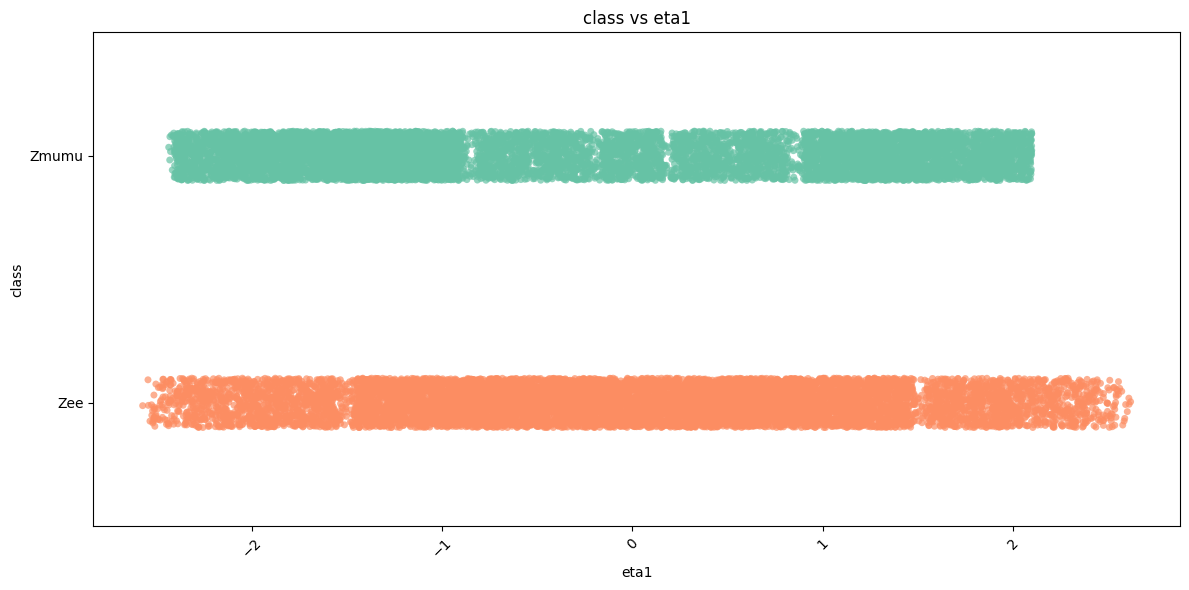

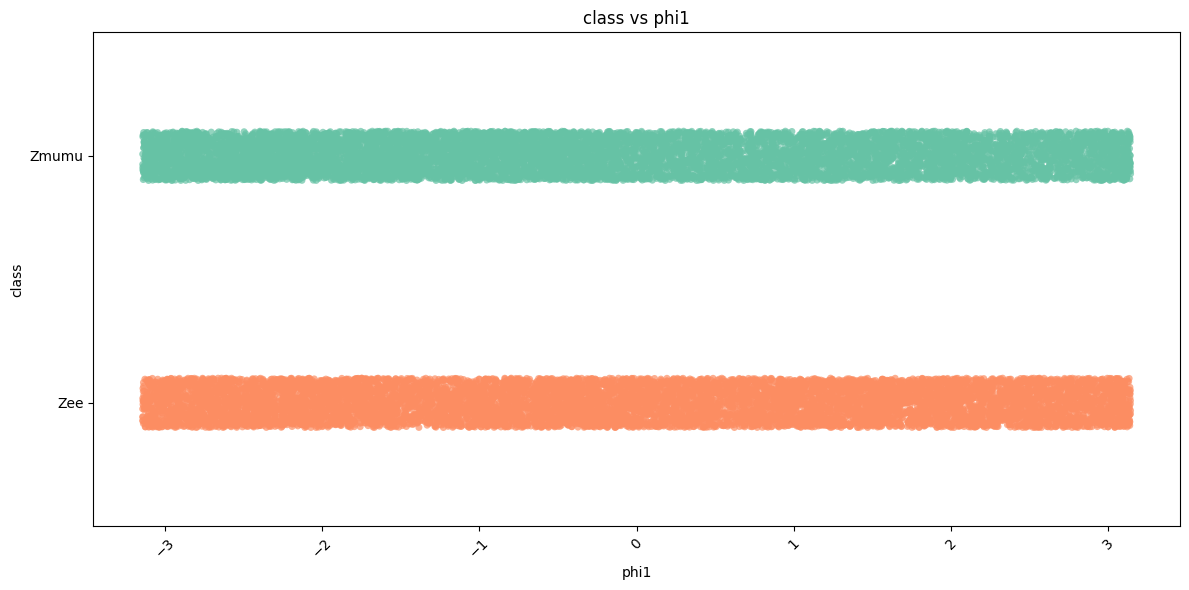

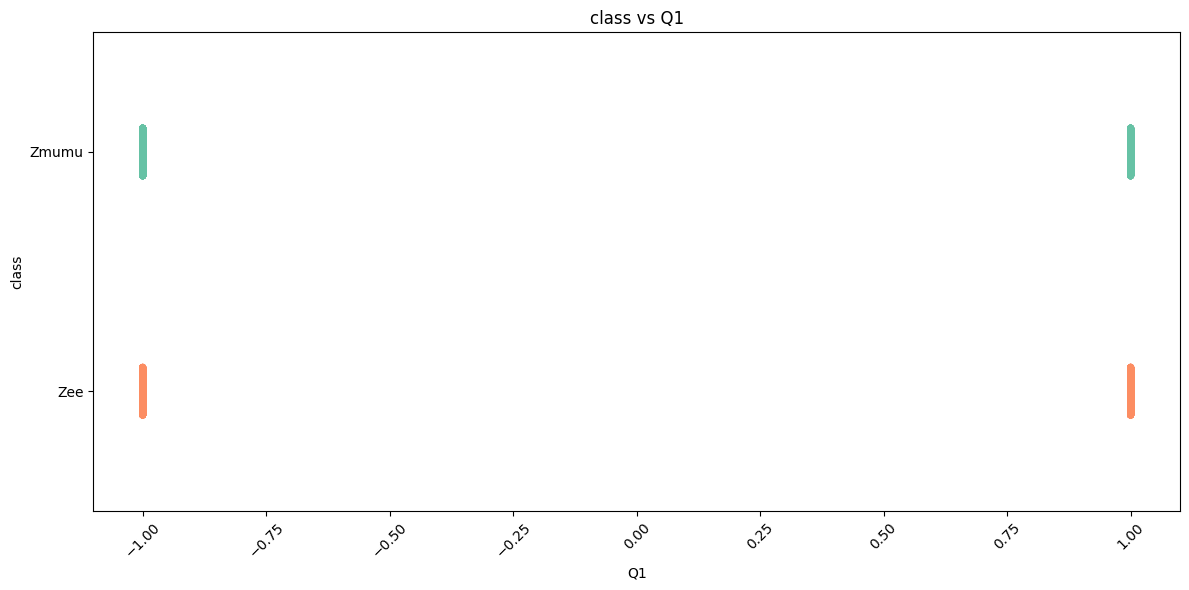

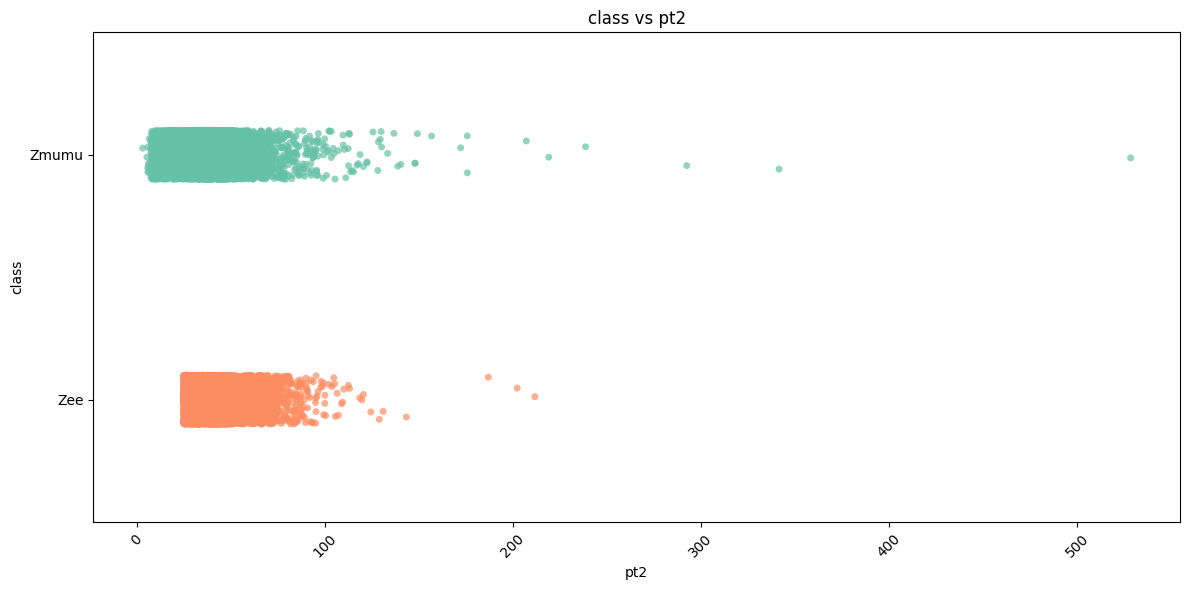

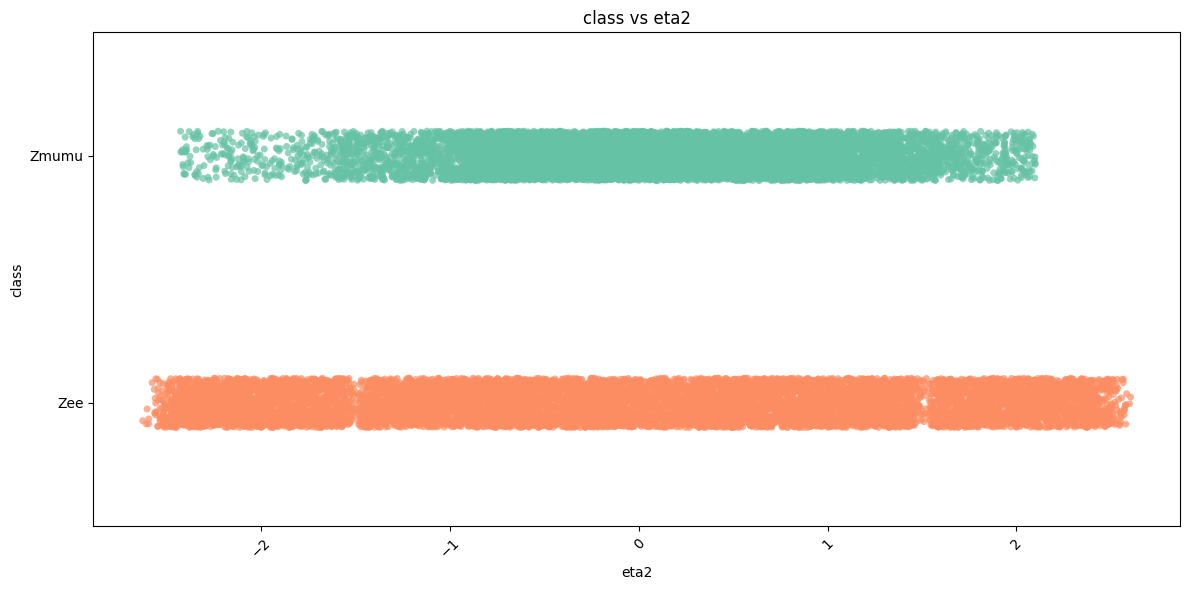

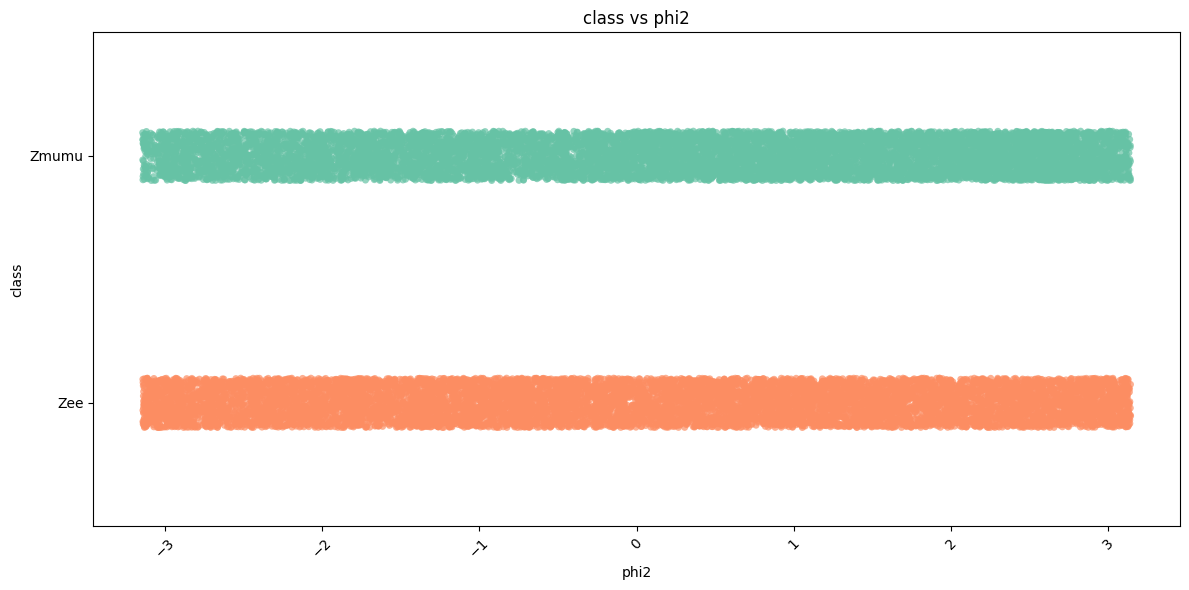

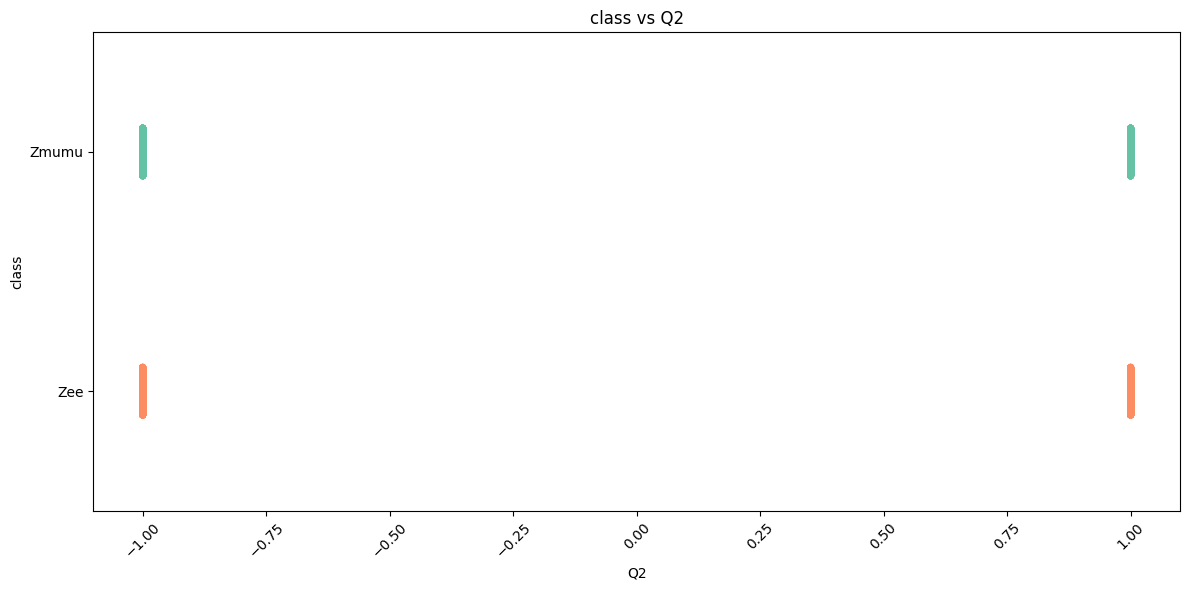

In [4]:
# Deeper / Denser GNN for Kaggle (full-batch GCN implemented in PyTorch)
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import warnings

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.neighbors import kneighbors_graph
from scipy import sparse

import torch
import torch.nn as nn
import torch.optim as optim

warnings.filterwarnings("ignore")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", DEVICE)

# --- Kaggle paths (adjust dataset folder name if needed) ---
DATA_PATH = "/kaggle/input/higgs-train/Z_boson-2.csv"
OUTPUT_DIR = "/kaggle/working/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# --- Load dataset ---
df = pd.read_csv(DATA_PATH)
print("Data loaded successfully. Shape:", df.shape)

# --- Label encode categorical features (if any) ---
categorical_features = [
    # add categorical feature names here if present
]

label_encoders = {}
for col in categorical_features + ["class"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

# --- Features & Target ---
X = df.drop("class", axis=1)
y = df["class"].astype(int)

# --- Scale features ---
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# --- Train-test split (we produce indices so we can create masks for the graph) ---
train_idx, test_idx = train_test_split(
    np.arange(len(X_scaled)), test_size=0.1, random_state=42, stratify=y
)
train_mask = np.zeros(len(X_scaled), dtype=bool)
test_mask = np.zeros(len(X_scaled), dtype=bool)
train_mask[train_idx] = True
test_mask[test_idx] = True

# --- Build k-NN graph (sparse adjacency) ---
K = 10
A_knn = kneighbors_graph(X_scaled, n_neighbors=K, mode='connectivity', include_self=False)
A_sym = 0.5 * (A_knn + A_knn.T)
A_sym.setdiag(1.0)

# --- Normalize adjacency: D^-0.5 * A * D^-0.5 ---
A = A_sym.tocsr().astype(np.float32)
deg = np.array(A.sum(1)).flatten()
deg_inv_sqrt = np.power(deg, -0.5, where=deg>0)
deg_inv_sqrt[np.isinf(deg_inv_sqrt)] = 0.0
D_inv_sqrt = sparse.diags(deg_inv_sqrt)
A_norm = D_inv_sqrt @ A @ D_inv_sqrt

# Convert normalized adjacency to torch sparse_coo_tensor
A_coo = A_norm.tocoo()
indices = np.vstack((A_coo.row, A_coo.col)).astype(np.int64)
values = A_coo.data.astype(np.float32)
i = torch.LongTensor(indices)
v = torch.FloatTensor(values)
A_torch = torch.sparse_coo_tensor(i, v, (len(X_scaled), len(X_scaled))).coalesce().to(DEVICE)

# --- Prepare feature and label tensors ---
X_tensor = torch.tensor(X_scaled, dtype=torch.float32, device=DEVICE)
y_tensor = torch.tensor(y.values, dtype=torch.long, device=DEVICE)
train_mask_t = torch.tensor(train_mask, dtype=torch.bool, device=DEVICE)
test_mask_t = torch.tensor(test_mask, dtype=torch.bool, device=DEVICE)

# --- Define a deeper GCN with BatchNorm, Dropout, Residuals ---
class GCNBlock(nn.Module):
    def __init__(self, in_dim, out_dim, dropout=0.4, use_bn=True):
        super().__init__()
        self.linear = nn.Linear(in_dim, out_dim, bias=False)
        self.use_bn = use_bn
        if use_bn:
            self.bn = nn.BatchNorm1d(out_dim)
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        # if dims match, residual connection can be applied externally

    def forward(self, x, A_sparse):
        x = self.linear(x)                     # (N, out_dim)
        x = torch.sparse.mm(A_sparse, x)       # (N, out_dim)
        if self.use_bn:
            # BatchNorm expects (batch, features) - here batch is N (nodes)
            x = self.bn(x)
        x = self.act(x)
        x = self.dropout(x)
        return x

class DeepGCN(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes, dropout=0.4):
        super().__init__()
        dims = [input_dim] + hidden_dims
        self.blocks = nn.ModuleList()
        for i in range(len(hidden_dims)):
            self.blocks.append(GCNBlock(dims[i], dims[i+1], dropout=dropout, use_bn=True))
        # final linear to classes (no A multiplication; or use another GCNBlock)
        self.classifier = nn.Linear(dims[-1], num_classes)
        # optional projection for residual when dims change
        self.projections = nn.ModuleList()
        for i in range(len(hidden_dims)):
            if dims[i] != dims[i+1]:
                self.projections.append(nn.Linear(dims[i], dims[i+1], bias=False))
            else:
                self.projections.append(nn.Identity())

    def forward(self, x, A_sparse):
        for idx, block in enumerate(self.blocks):
            out = block(x, A_sparse)
            # apply residual if shapes allow (project previous x -> out dim)
            proj = self.projections[idx]
            res = proj(x)
            x = out + res  # residual connection
        # final classification from node embeddings
        logits = self.classifier(x)
        return logits

# --- Instantiate model with larger widths (denser) ---
input_dim = X_tensor.shape[1]
hidden_dims = [512, 256, 128]   # denser/wider layers
num_classes = int(y_tensor.max().item()) + 1

model = DeepGCN(input_dim=input_dim, hidden_dims=hidden_dims, num_classes=num_classes, dropout=0.4).to(DEVICE)
print(model)

# --- Loss, optimizer, scheduler ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, verbose=True)

# --- Training loop (full-batch) with gradient clipping and LR scheduling ---
epochs = 300
best_val_acc = 0.0
best_state = None

for epoch in range(1, epochs + 1):
    model.train()
    optimizer.zero_grad()
    out = model(X_tensor, A_torch)  # (N, num_classes)
    loss = criterion(out[train_mask_t], y_tensor[train_mask_t])
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)  # gradient clipping
    optimizer.step()

    # evaluate
    model.eval()
    with torch.no_grad():
        logits = model(X_tensor, A_torch)
        preds = logits.argmax(dim=1)

        train_acc = (preds[train_mask_t] == y_tensor[train_mask_t]).float().mean().item()
        test_acc = (preds[test_mask_t] == y_tensor[test_mask_t]).float().mean().item()

    # Step scheduler on validation (test) accuracy
    scheduler.step(test_acc)

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:03d} | Loss: {loss.item():.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")

    # track best
    if test_acc > best_val_acc:
        best_val_acc = test_acc
        best_state = {k: v.cpu() for k, v in model.state_dict().items()}

# restore best
if best_state is not None:
    model.load_state_dict(best_state)
print("Training finished. Best test accuracy:", best_val_acc)

# --- Final evaluation: classification report on test set ---
model.eval()
with torch.no_grad():
    logits = model(X_tensor, A_torch)
    preds_all = logits.argmax(dim=1).cpu().numpy()

y_test_true = y_tensor[test_mask_t].cpu().numpy()
y_test_pred = preds_all[test_mask_t.cpu().numpy()]

print("\nClassification report (test set):")
print(classification_report(y_test_true, y_test_pred))

# --- Save model & preprocessors (Kaggle working dir) ---
torch.save(model.state_dict(), os.path.join(OUTPUT_DIR, "gnn_model-higgs_deeper.pth"))
joblib.dump(scaler, os.path.join(OUTPUT_DIR, "minmax_scaler-gnn-higgs.pkl"))
joblib.dump(label_encoders, os.path.join(OUTPUT_DIR, "label_encoders-gnn-higgs.pkl"))
print("Saved deeper GNN model and preprocessors to", OUTPUT_DIR)

# --- 1. Plot classification report as heatmap ---
report_dict = classification_report(y_test_true, y_test_pred, output_dict=True)
report_df = pd.DataFrame(report_dict).iloc[:-1, :-1]  # Exclude avg/total row

plt.figure(figsize=(10, 6))
sns.heatmap(report_df, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Classification Report Heatmap (Deeper GNN)")
plt.show()

# --- 2. Scatter plots instead of bar plots ---
df_raw = df.copy()
for col, le in label_encoders.items():
    df_raw[col] = le.inverse_transform(df[col])

features_to_plot = [
    "Run", "Event", "pt1", "eta1", "phi1", "Q1",
    "pt2", "eta2", "phi2", "Q2"
]

for feature in features_to_plot:
    plt.figure(figsize=(12, 6))
    sns.stripplot(
        x=feature, y="class", data=df_raw,
        jitter=True, palette="Set2", alpha=0.7, size=5
    )
    plt.title(f"class vs {feature}")
    plt.xlabel(feature)
    plt.ylabel("class")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
